In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random

from keras.preprocessing import image

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from ssd_utils import BBoxUtility
from gen import Generator
from ssd_training import MultiboxLoss
from ssd_layer import DefaultBox

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(398, 710, 3)


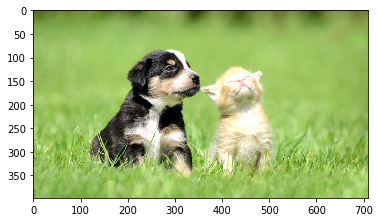

In [3]:
img_path = 'test1.jpg'
img = image.load_img(img_path)
img = image.img_to_array(img)
print(img.shape)
plt.imshow(img/225.)  #(y, x, c)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


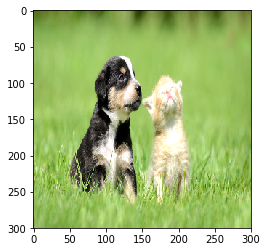

In [4]:
img_path = 'test1.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
plt.imshow(img/225.)

In [5]:
locs = np.array([[50, 50, 150, 150],
               [100, 150, 170, 220],
                [0, 0, 100, 100]]) # (ymin, xmin, ymax, xmax)

In [6]:
labels = np.array([[0,0],
                  [1,0],
                  [0,1]])

In [7]:
boxes = np.hstack([locs, labels])

In [8]:
boxes

array([[ 50,  50, 150, 150,   0,   0],
       [100, 150, 170, 220,   1,   0],
       [  0,   0, 100, 100,   0,   1]])

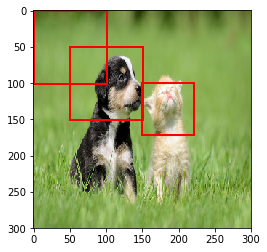

In [9]:
plt.imshow(img / 255.)
axis = plt.gca()

for i in range(len(locs)):
    ymin = locs[i, 0]
    xmin = locs[i, 1]
    ymax = locs[i, 2]
    xmax = locs[i, 3]
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    rect = plt.Rectangle(*coords, fill=False, edgecolor='red', linewidth=2)
    axis.add_patch(rect)

plt.show()

## pretraining model

In [10]:
NUM_CLASSES =2
input_shape = (300, 300, 3) # (y, x, c)

In [21]:
img_size = input_shape[:2]
priors = np.zeros(8).reshape(1,-1)
aspects = [1.0, 1/2, 3, 1/3, 1.0, 2]

det_grid = np.array([3, 3])
steps = (img_size / det_grid).astype(np.int)

y_cent_arr = (np.linspace(steps[0]/2, img_size[0]-steps[0]/2, det_grid[0]))
x_cent_arr = (np.linspace(steps[1]/2, img_size[1]-steps[1]/2, det_grid[1]))
y_cent, x_cent = np.meshgrid(y_cent_arr, x_cent_arr)
y_cent = y_cent.reshape(-1,1)
x_cent = x_cent.reshape(-1,1)

y_var = np.ones_like(y_cent).reshape(-1,1) * 0.1
x_var = np.ones_like(x_cent).reshape(-1,1) * 0.1
h_var = np.ones_like(y_cent).reshape(-1,1) * 0.2
w_var = np.ones_like(x_cent).reshape(-1,1) * 0.2

for asp in aspects:
    h_arr = np.ones(det_grid[0]**2).reshape(-1,1) * steps[0] * asp
    w_arr = np.ones(det_grid[1]**2).reshape(-1,1) * steps[1] / asp
    y_mins  = np.clip(y_cent - h_arr // 2, 0, img_size[0])
    x_mins  = np.clip(x_cent - h_arr // 2, 0, img_size[1])
    y_maxs  = np.clip(y_cent + h_arr // 2, 0, img_size[0])
    x_maxs = np.clip(x_cent + w_arr // 2, 0, img_size[1])
    priors_pos = np.hstack([y_mins, x_mins, y_maxs, x_maxs])
    priors_var = np.hstack([y_var, x_var, h_var, w_var])
    priors_dum = np.hstack([priors_pos, priors_var])
    priors = np.vstack([priors, priors_dum])

priors = priors[1:]
priors.shape #(4*4*6, 8)

(54, 8)

In [22]:
bbox_util = BBoxUtility(NUM_CLASSES,  priors)

In [25]:
bbox_util.encode_box(box=locs[0])

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0. 

In [18]:
bbox_util.assign_boxes(boxes=boxes)[1]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])